# Model Building / Training / Optimization / Evaluation
The following notebook aims to identify feature importance, compare multiple models, perform hyperparameter tuning, and analyze the results. 

## Use Case: Predict Hotel Booking Cancellations
### Problem Description: 
Hotel cancellations pose a challenge in the hospitality business. Clients expect to be able to enjoy the advertised amenities. Ensuring everything runs smoothly requires careful planning and is always affected by the number of guests. Hence cancelled bookings lead to revenue loss and inefficiencies in resource allocation. A variety of factors may lead to a cancellation. 

### Solution 
Supervised machine learning, could help mitigate the issues resulting from cancellations that seem to be happening unexpectedly. A classification model can be trained using historical booking data in order to predict whether or not a combination of features is likely to lead to a cancellation. Specifically, the goal is to predict the number of cancellations for a sufficiently sized dataset. 

### Github Repository 
https://github.com/tseidel0509/Supervised_ML.git 

### Data Source
The dataset used is from Kaggle and contains hotel reservations, a total of 32 columns with one target feature. It consists of numerical and categorical features. 

Hotel Booking Dataset. (2022, June 5). Kaggle. https://www.kaggle.com/datasets/somnathnaskar/hotel-booking-dataset?select=hotel_bookings.csv

In [133]:
import sklearn
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, classification_report, r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tabulate import tabulate
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [14]:
file_path = "/Users/timseidel/Documents/Graduate_Certificate/FinalProject_SupervisedLearning/archive/encoded_hotel_data.csv"
df_train = pd.read_csv(file_path)
df_train

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_cancellations,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,1,0,7,2015,5,1,0,1,1,0.0,...,0,0,2,0,0,0,2,75.00,0,0
1,1,0,13,2015,5,1,0,1,1,0.0,...,0,0,0,0,0,0,2,75.00,0,0
2,1,0,14,2015,5,1,0,2,2,0.0,...,0,0,0,0,0,0,2,98.00,0,1
3,1,0,14,2015,5,1,0,2,2,0.0,...,0,0,0,0,0,0,2,98.00,0,1
4,1,0,0,2015,5,1,0,2,2,0.0,...,0,2,2,0,0,0,2,107.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116954,0,0,23,2017,1,30,2,5,2,0.0,...,0,0,0,0,0,0,2,96.14,0,0
116955,0,0,102,2017,1,31,2,5,3,0.0,...,0,4,4,0,0,0,2,225.43,0,2
116956,0,0,34,2017,1,31,2,5,2,0.0,...,0,3,3,0,0,0,2,157.71,0,4
116957,0,0,109,2017,1,31,2,5,2,0.0,...,0,0,0,0,0,0,2,104.40,0,0


#### Split into Target and Features

In [18]:
target = df_train['is_canceled']
features = df_train.drop('is_canceled', axis = 1)
features.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,previous_cancellations,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,1,7,2015,5,1,0,1,1,0.0,0,...,0,0,2,0,0,0,2,75.0,0,0
1,1,13,2015,5,1,0,1,1,0.0,0,...,0,0,0,0,0,0,2,75.0,0,0
2,1,14,2015,5,1,0,2,2,0.0,0,...,0,0,0,0,0,0,2,98.0,0,1
3,1,14,2015,5,1,0,2,2,0.0,0,...,0,0,0,0,0,0,2,98.0,0,1
4,1,0,2015,5,1,0,2,2,0.0,0,...,0,2,2,0,0,0,2,107.0,0,0


#### Scale the Features

In [22]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#### Create a Train and Test Split

In [25]:
# Stratify maintains the class balance in training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.2, random_state=42, stratify=target
)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (93567, 24), Test set: (23392, 24)


#### Random Forest for Feature Importance and Selection 

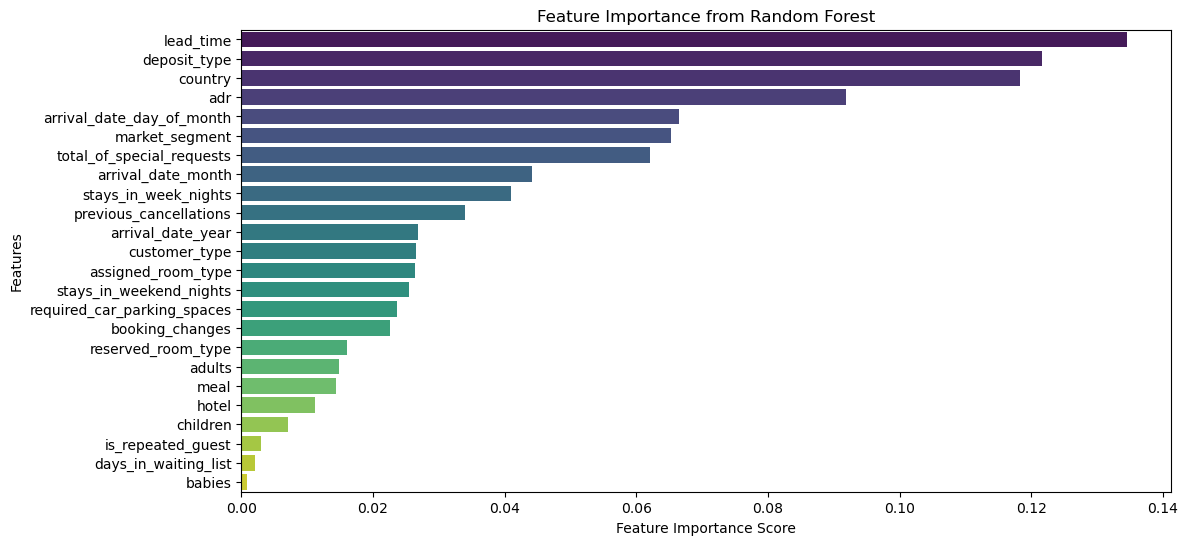

In [39]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_
feature_names = features.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], hue=importance_df['Feature'], palette='viridis')

plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance from Random Forest")
plt.show()

Given the above graph the 2 most important features are lead_time and deposit_type. The data exploration clearly showed that lead_time influenced the cancellation status, hence these results underpin those findings. For the purpose of this exploration the 10 most important features plus the hotel column shall be chosen. One could also work with a threshold value, but defining one would require greater understanding of this dataset and similar ones. 

In [48]:
top_features_array = importance_df['Feature'].iloc[:10].values
top_features_array = np.append(top_features_array, 'hotel')
top_features = features[top_features_array]
top_features

,lead_time,deposit_type,country,adr,arrival_date_day_of_month,market_segment,total_of_special_requests,arrival_date_month,stays_in_week_nights,previous_cancellations,hotel
0,7,0,59,75.00,1,3,0,5,1,0,1
1,13,0,59,75.00,1,2,0,5,1,0,1
2,14,0,59,98.00,1,6,1,5,2,0,1
3,14,0,59,98.00,1,6,1,5,2,0,1
4,0,0,135,107.00,1,3,0,5,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...
116954,23,0,15,96.14,30,5,0,1,5,0,0
116955,102,0,56,225.43,31,6,2,1,5,0,0
116956,34,0,43,157.71,31,6,4,1,5,0,0
116957,109,0,59,104.40,31,6,0,1,5,0,0


#### Scale and Train Test Split Again
Given that the most important features have been chosen using the RandomForestClassifier, the initial values corresponding to those columns need to now be scaled given that the scaling may yield different results because less features are being scaled. Also a new train test split needs to be performed. 

In [54]:
scaler = StandardScaler()
top_features_scaled = scaler.fit_transform(top_features)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    top_features_scaled, target, test_size=0.2, random_state=42, stratify=target
)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (93567, 11), Test set: (23392, 11)


#### Multi-Model Training
This code block shall build and train multiple models and evaluate them based on their cross-validation accuracy score. The model that yields the highest accuracy shall be chosen to perform hyperparameter tuning on. Training time shall also be considered. 

Collinearity can be an issue for Logistic Regression and SVC as strongly correlated features can lead to unstable coefficient estimates for linear regression and redundant features can impact margin calculations for SVC. The other models don't really suffer from this.

In [75]:
models = [
    LogisticRegression(max_iter=500),
    DecisionTreeClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(),
    SVC()
]

accuracy_scores = []
training_times = []

for model in models: 
    print(f"\nFitting the model: {model.__class__.__name__}")

    # Measure training time
    start_time = time.time()
    # 5-Fold Cross Validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    end_time = time.time()
    
    # Calculate mean accuracy and training time
    mean_cv_accuracy = np.mean(cv_scores)
    training_time = end_time - start_time

    accuracy_scores.append(mean_cv_accuracy)
    training_times.append(training_time)

    print(f"Mean CV accuracy score: {mean_cv_accuracy:.2f}")
    print(f"Training time: {training_time:.2f} seconds")

highest_accuracy = np.argmax(accuracy_scores)
best_model = models[highest_accuracy]

print(f"\nThe model with the highest accuracy is: {best_model.__class__.__name__}")
print(f"Accuracy: {accuracy_scores[highest_accuracy]:.2f}")
print(f"Training Time: {training_times[highest_accuracy]:.2f} seconds")
    


Fitting the model: LogisticRegression
Mean CV accuracy score: 0.78
Training time: 0.41 seconds

Fitting the model: DecisionTreeClassifier
Mean CV accuracy score: 0.82
Training time: 1.00 seconds

Fitting the model: GradientBoostingClassifier
Mean CV accuracy score: 0.82
Training time: 19.09 seconds

Fitting the model: XGBClassifier
Mean CV accuracy score: 0.84
Training time: 0.64 seconds

Fitting the model: SVC
Mean CV accuracy score: 0.81
Training time: 259.10 seconds

The model with the highest accuracy is: XGBClassifier
Accuracy: 0.84
Training Time: 0.64 seconds


Additionally to being the best model, XGB was the 2nd quickest to fit. Hence, the trade-off between accuracy and training time is minimal. Also XGBClassifier is not affected by collinearity therefore this does not need to be considered from here on out. 

#### Perform Hyperparameter Tuning using RandomSearchCV
While RandomSearchCV may not be a sophisticated Hyperparameter Tuning technique such as Optuna it is still beneficial to perform. 

In [87]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [1, 2, 5, 10, 50, 100, 200, 300],  # Number of trees
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],  # Step size shrinkage
    'max_depth': [1, 3, 5, 7, 10],  # Tree depth
    'subsample': [0.1, 0.4, 0.6, 0.8, 1.0],  # Percentage of data per tree
    'colsample_bytree': [0.1, 0.4, 0.6, 0.8, 1.0],  # Features per tree
    'gamma': [0, 0.1, 0.2, 0.3],  # Minimum loss reduction to make a split
    'reg_lambda': [0.01, 0.1, 1, 10]  # L2 regularization
}

# Randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    xgb, param_distributions=param_grid, n_iter=35, cv=5, scoring='accuracy', 
    verbose=1, n_jobs=-1, random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Print best parameters and accuracy
print("\nBest Hyperparameters:", random_search.best_params_)
print("Best Accuracy Score: {:.4f}".format(random_search.best_score_))
best_xgb = random_search.best_estimator_

Fitting 5 folds for each of 35 candidates, totalling 175 fits

Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 0.1, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}
Best Accuracy Score: 0.8585


#### Retrain XGBoost on Best Parameters and Predict
It should be noted that there may exist data leakage given that the model is being retrained on the same dataset. But training and test sets have been strictly split, therefore an evaluation on the test set will not bei influenced by this. 

In [99]:
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1] # Probabilities for AUC

#### Results
The results comprise accuracy score, roc_auc_score, classification report, confusion matrix (showing true positive, true negatives, false positives, and false negatives), and ROC Curve

Test Accuracy: 0.8647
ROC-AUC Score: 0.9343

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     14602
           1       0.85      0.78      0.81      8790

    accuracy                           0.86     23392
   macro avg       0.86      0.85      0.85     23392
weighted avg       0.86      0.86      0.86     23392



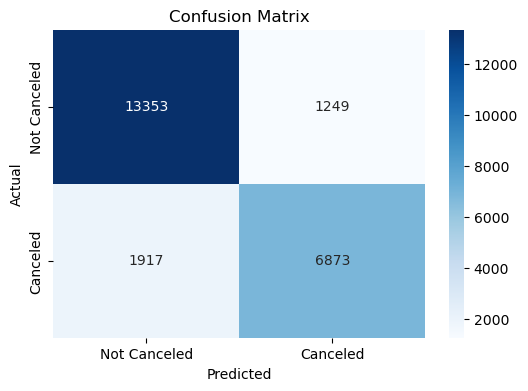

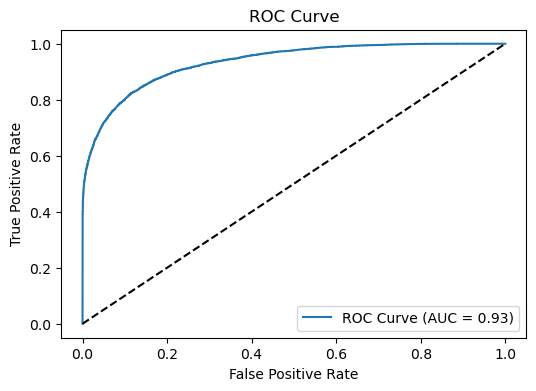

In [109]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Not Canceled", "Canceled"], yticklabels=["Not Canceled", "Canceled"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#### Results Analysis
- Train vs. Test Accuracy: given that the model performed even slightly better (86.5% vs 85.9%) on the test set one can say it generalized well, suggesting little to no overfitting
- Classification Report and Confusion Matrix: the latter visualizes the values of the classification report in terms of absolute values.

> Precision: The model accurately predicts 'Not Canceled' 87% and'Canceled' 85% of the time

> Recall: The model accurately identifies 91% of actual 'Not Cancelled' bookings, but only 78% of actual 'Canceled' bookings

> F1: Balances precision and recall. 0.89 for 'Not Canceled' vs 0.81 for 'Canceled' suggests slightly better performance on non cancellations than cancellations

- ROC Curve: visual depiction of the True Positive and False Positive Rate. The area under the curve is the probability that the model, if given a randomly chosen positive and negative sample, will rank the positive higher.

> A model with an AUC curve that is closer to the top left corner is considered better

- Business Implications:

> In 1,249 cases customers ending up "showing up" although they were classified as cancellations (False Positives). This could result in overbooking if the hotels were to follow the model's recommendation, causing room shortages.

> In 1,917 cases customers ended up cancelling although they were classified otherwise (False  Negatives). If the hotels were unable to resell these rooms they would be left with a revenue loss. Potentially some of the False Positives and False Negatives could cancel out negative impact in reality.

In reality it is more likely that hotels remain under- than overbooked, therefore it makes the most sense to improve the model's performance on False Negatives. 

#### Further Explorations
The following could be explored if given more time: 
- Perform analysis on wrongly classified data points (False Positives and False Negatives)
- Calculate Performance Metrics separately for each hotel type
- Perform training separately on the respective hotel's data instead of combining both into one dataset for training
